**Contexte de l'étude**

Dans ma famille, nous sommes de grands amateurs d'échecs. Bien que nous soyons à des années-lumière d'avoir le niveau des joueurs professionnels, nous jouons très régulièrement et le grand jeu entre nous est de savoir qui sera le champion de la famille en fonction de nos différents classements ELO.

Évidemment, en bons joueurs d'échecs que nous sommes, nous avons du mal à admettre lorsque nous jouons mal et/ou que nos adversaires nous ont surpassé dans une partie. Alors, lorsque les défaites s'accumulent, c'est forcément la faute du système (en l'occurrence chess.com ici) qui doit manipuler les adversaires que l'on rencontre pour nous faire perdre.

Un soir, à table, la discussion porte sur ce sujet, et je suis étonné de constater que nous partageons tous le même ressenti : parfois, nous enchaînons les défaites. Nous avons l'impression de jouer correctement mais rien n'y fait, nous perdons face à nos adversaires. Parfois, cela peut durer 3, 4, 5 parties voire plus ! Si nous partageons cette même impression, c'est donc forcément que chess.com choisit des adversaires meilleurs que nous pour rééquilibrer notre classement !

C'en est trop, j'ai besoin de savoir !

Alors sommes-nous de mauvaise foi ou chess.com choisit-il réellement des adversaires statistiquement meilleurs dans le but de nous faire perdre ? C'est ce que nous allons étudier.

**Etapes de l'étude :**

1 - Extraire l'historique de parties via l'API chess.com.

2 - Identifier dans l'historique les séries de défaites. Nous considérons qu'une série de défaites débute à partir de 4.

3 - Nous devrons extraire l'historique de chacun des adversaires rencontrés (nous étudierons les 100 parties précédant la nôtre) en fonction des séries de défaites identifiées.

4 - Réaliser une analyse de données pertinente pour répondre à la question de l'étude.


# <font color = 'green'> Bibliothèques

In [1]:
from chessdotcom import Client, get_player_game_archives, get_player_current_games_to_move
import pprint
import requests
import re
import pandas as pd
from pandasql import sqldf
from datetime import datetime, timedelta
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import fonctions_file as f
import re
import warnings

# Update the User-Agent header for chessdotcom client
Client.request_config['headers'] = {
    "User-Agent": "My Python Application"
}


username = 'deutschequalitat'

# <font color='green'> Import des données 

In [6]:
#On génère tout l'historique du joueur qui nous intéresse
#df_players_historic = f.get_player_historic(username)
#df_players_historic.to_csv(f'./dataframes_saved/df_players_historic_{username}.csv', index=False)
#df_players_historic.head()

In [7]:
#On filtre uniquement les séries de défaites
#df_losing_streak = f.get_df_losing_streak(df_players_historic)
#df_losing_streak.to_csv(f'./dataframes_saved/df_losing_streak_{username}.csv', index=False)

In [8]:
#On importe les 100 partie
#df_opponents_last_100 = f.get_df_opponents_last_100_games(username, df_losing_streak)

# <font color='green'> Data loading

In [9]:
#Historique du joueur qu'on étudie, ici deutschequalitat
df_players_historic_deutschequalitat = pd.read_csv(f"./dataframes_saved/df_players_historic_{username}.csv")
df_players_historic_deutschequalitat.head()

,full_histo_idx,game_id,year_month,time_class,end_time,player_username,player_color,player_rating,opponent_username,opponent_color,opponent_rating,player_result
0,234,5528690521,2020/10,rapid,1601660042,deutschequalitat,white,819,pgupta29,black,996,lose
1,235,5528777099,2020/10,rapid,1601661187,deutschequalitat,white,710,AlanJavier9,black,857,lose
2,236,5532006317,2020/10,rapid,1601726701,deutschequalitat,black,616,skinnygorilla,white,698,lose
3,237,5532017711,2020/10,rapid,1601727088,deutschequalitat,white,544,JayC10101,black,622,lose
4,238,5532821435,2020/10,rapid,1601740899,deutschequalitat,white,599,donorBaby,black,512,win


In [10]:
#Historique des séries de défaites du joueur qu'on étudie, ici deutschequalitat
df_losing_streak_deutschequalitat = pd.read_csv(f"./dataframes_saved/df_losing_streak_{username}.csv")
df_losing_streak_deutschequalitat.head()

,rapid_histo_idx,full_histo_idx,game_id,year_month,time_class,end_time,player_username,player_color,player_rating,opponent_username,opponent_color,opponent_rating,player_result
0,0,234,5528690521,2020/10,rapid,1601660042,deutschequalitat,white,819,pgupta29,black,996,lose
1,1,235,5528777099,2020/10,rapid,1601661187,deutschequalitat,white,710,AlanJavier9,black,857,lose
2,2,236,5532006317,2020/10,rapid,1601726701,deutschequalitat,black,616,skinnygorilla,white,698,lose
3,3,237,5532017711,2020/10,rapid,1601727088,deutschequalitat,white,544,JayC10101,black,622,lose
4,22,256,5540873193,2020/10,rapid,1601900588,deutschequalitat,black,626,hemuApex,white,672,lose


In [11]:
#Historiques des 100 dernières parties jouées par les adversaires avant d'affonter deutschequalitat
df_opponents_last_100 = pd.read_csv(f"./dataframes_saved/df_opponents_last_100_games_{username}.csv")
df_opponents_last_100.head()

,full_histo_idx,game_id,year_month,time_class,end_time,player_username,player_color,player_rating,opponent_username,opponent_color,opponent_rating,player_result,game_id_ref
0,140,2952950143,2018/07,rapid,1532133541,pgupta29,black,1085,Abu_Yaman2018,white,976,win,5528690521
1,141,2953187738,2018/07,rapid,1532147284,pgupta29,white,1075,edward1517,black,1031,lose,5528690521
2,142,2956686147,2018/07,rapid,1532286064,pgupta29,black,1068,mrclaude,white,1121,lose,5528690521
3,143,2963828784,2018/07,rapid,1532565147,pgupta29,white,1061,stony930,black,1117,lose,5528690521
4,375,3554020007,2019/03,rapid,1553213075,pgupta29,white,1075,camelim,black,861,win,5528690521


# <font color='green'> Data understanding

In [13]:
print ('Nombre de lignes dans df :', df_opponents_last_100.shape[0])
print ('Nombre de player_username uniques dans df :', df_opponents_last_100['player_username'].nunique())
print ('Nombre de game_id uniques dans df :', df_opponents_last_100['game_id'].nunique())
print ('Nombre de game_id/player_username :', df_opponents_last_100['game_id'].nunique()/df_opponents_last_100['player_username'].nunique())

Nombre de lignes dans df : 48966
Nombre de player_username uniques dans df : 501
Nombre de game_id uniques dans df : 48560
Nombre de game_id/player_username : 96.92614770459082


Première constatation, il y a en moyenne 96 parties importées par utilisateurs. Cela signifie que certains `player_usernanme` sont associés à moins de 100 parties.

In [14]:
q="""
SELECT
    player_username,
    COUNT(game_id) AS nbr_of_games_per_player
FROM df_opponents_last_100
GROUP BY player_username
"""
df_nbr_of_games_per_player = sqldf(q)

print('Minimum de parties pour un joueur :', df_nbr_of_games_per_player.min())
print('Maximum de parties pour un joueur :', df_nbr_of_games_per_player.max())

Minimum de parties pour un joueur : player_username            06zx1400
nbr_of_games_per_player           2
dtype: object
Maximum de parties pour un joueur : player_username            zubipl84
nbr_of_games_per_player         500
dtype: object


<font color = 'green'>
    
Nous allons réaliser une courbe de distribution pour observer plus correctement comment la répartition du nombre de parties par joueurs se fait et ainsi, netttoyer les données en conséquence.

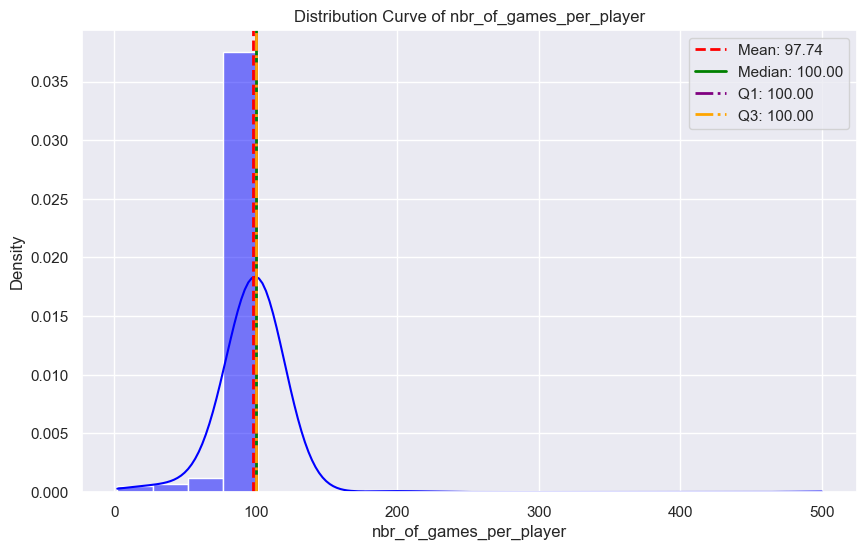

In [35]:
distribution_curve(df_nbr_of_games_per_player, 'nbr_of_games_per_player')

<font color = 'green'>
    
On constate que la majeure partie des player_username sont bien associés à 100 parties étant donnés que la médiane, Q1 et Q3 sont tous égaux à 100.

<font color = 'blue'>
    
Pour les usernames supérieurs à 100, cela signifie que le joueur `deutschequalitat` a réalisé plusieurs parties contre un même adversaire, et qu'il y a donc eu autant d'import de 100 partie que de parties jouées ensemble.

Pour les usernames avec moins de 100 parties, cela peut provenir de joueurs qui n'avaient pas encore 100 parties dans leur historique au moment où `deutschequalitat` les a affrontés.

In [20]:
print('Nombre de joueur avec 100 parties:', df_nbr_of_games_per_player[df_nbr_of_games_per_player['nbr_of_games_per_player']==100].shape[0])

Nombre de joueur avec 100 parties: 455


<font color ='green'>
    
Nous allons réaliser des courbes de distrbution pour les 2 cas observer précédemment afinc d'arbitrer sur le fait de supprimer définitivement ces données de notre dataframe, ou de conserver tout ou une partie de celles-ci.

Nombre de joueur avec plus de 100 parties: 43


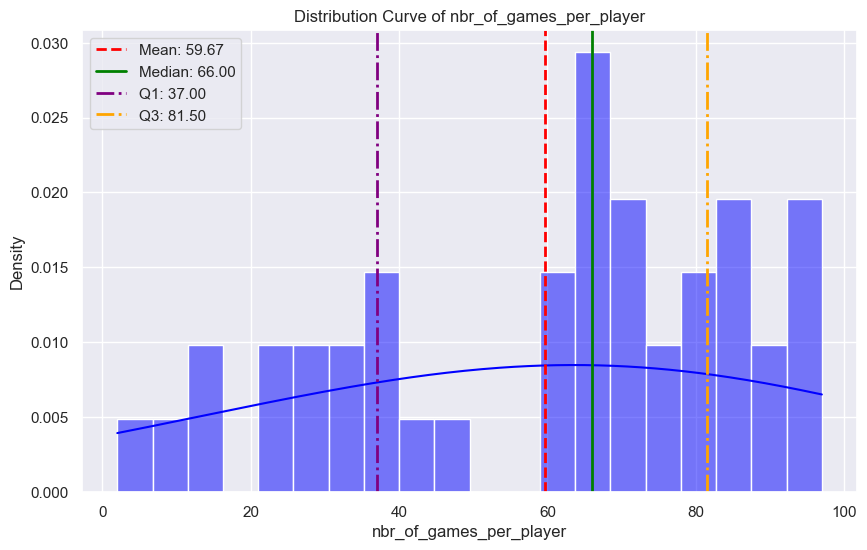

In [21]:
#Courbe de distribution des player_username avec moins de 100 parties connues
print('Nombre de joueur avec plus de 100 parties:', df_nbr_of_games_per_player[df_nbr_of_games_per_player['nbr_of_games_per_player']<100].shape[0])
distribution_curve(df_nbr_of_games_per_player[df_nbr_of_games_per_player['nbr_of_games_per_player']<100], 'nbr_of_games_per_player')

Nombre de joueur avec plus de 100 parties: 3


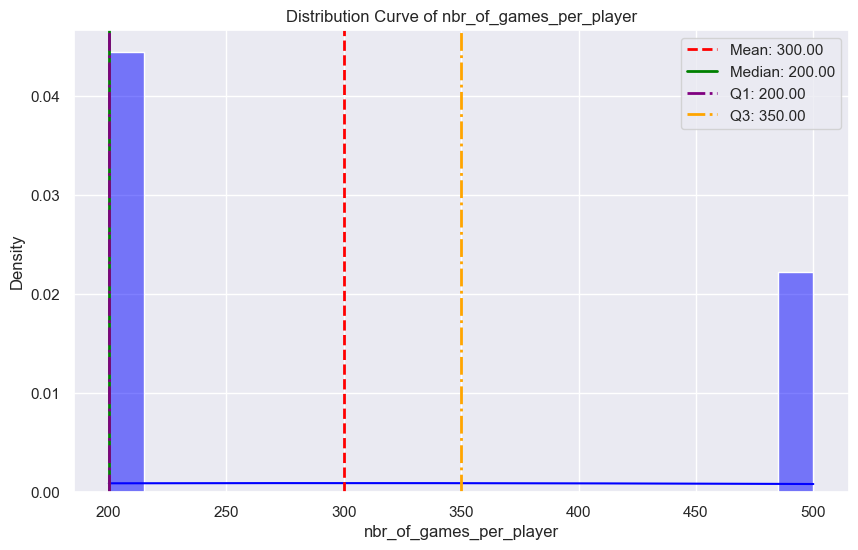

In [22]:
#Courbe de distribution des player_username avec plus de 100 parties connues
print('Nombre de joueur avec plus de 100 parties:', df_nbr_of_games_per_player[df_nbr_of_games_per_player['nbr_of_games_per_player']>100].shape[0])
distribution_curve(df_nbr_of_games_per_player[df_nbr_of_games_per_player['nbr_of_games_per_player']>100], 'nbr_of_games_per_player')

<font color = 'green'>

Pour les joueurs avec plus de 100 parties étant donnés qu'ils ne sont que 3, nous prennons la décision de les écarter de notre dataframe, car la réduction est très légère (<1% du dataframe) 

En revanche, pour les `player_username` avec un nombre de parties connues inférieur à 100, on en compte 43. Tous les écarter ferait perdre de la densité dans notre dataframe. Ainsi, pour garder un volume conséquent de données, nous prennons la décision d'écarter, dans le dataframe `df_opponents_last_100` dans le cas ou un, toutes les données où un `player_username` est asosicé à moins de 59 parties (seuil de la médiane).


Autrement, les données sont propres, car il a été fait en sorte en amont d'importer les données souhaitées et au bon format. 
    
**Résumé des actions à prendre**
- Supprimer les parties des `player_username` avec plus de 100 parties
- Supprimer les parties des `player_username` avec moins de 59 parties

# <font color='green'> Data cleaning

In [23]:
#On récupère les player_usernames qu'il faut garder (avec plus de 100 parties)
list_players_to_delete = df_nbr_of_games_per_player[df_nbr_of_games_per_player['nbr_of_games_per_player']>100]['player_username'].tolist()
list_all_players = df_opponents_last_100['player_username'].unique().tolist()

list_players_to_keep = [username for username in list_all_players if username not in list_players_to_delete]

#Retient dans le dataframe uniquement les joueurs de la liste
df_opponents_last_100_clean = df_opponents_last_100[df_opponents_last_100['player_username'].isin(list_players_to_keep)]



#On récupère les player_usernames qu'il faut garder (avec moins de 59 parties)
list_players_to_delete = df_nbr_of_games_per_player[df_nbr_of_games_per_player['nbr_of_games_per_player']<59]['player_username'].tolist()
list_all_players = df_opponents_last_100_clean['player_username'].unique().tolist() #On repart du dataframe filtré

list_players_to_keep = [username for username in list_all_players if username not in list_players_to_delete]

#Retient dans le dataframe uniquement les joueurs de la liste
df_opponents_last_100_clean = df_opponents_last_100_clean[df_opponents_last_100_clean['player_username'].isin(list_players_to_keep)]  

In [24]:
#On charge l'historique des 100 parties qui ont précédées chacune des parties perdue selon la liste du dataframe df_losing_streak

#On crée un dataframe dans lequel on charge les 100 parties du premier adversaire
game_id_reference = df_losing_streak_deutschequalitat['game_id'].iloc[0]
df_deutshchequalitat_last_100 = get_last_100_games_before_ref(game_id_reference, df_players_historic_deutschequalitat)

#Pour la suite on fait la même chose mais on ajoute à la suite du dataframe les parties des autres adversaires
for i in tqdm(range(1, df_losing_streak_deutschequalitat.shape[0]), desc="Chargement des données"):
    #On met à jour les variables
    game_id_reference = df_losing_streak_deutschequalitat['game_id'].iloc[i]

    #On ajoute à la suite les données chargées
    added_df = get_last_100_games_before_ref(game_id_reference, df_players_historic_deutschequalitat)
    df_deutshchequalitat_last_100 = pd.concat([df_deutshchequalitat_last_100, added_df], axis=0)

df_deutshchequalitat_last_100 = df_deutshchequalitat_last_100.reset_index()

Chargement des données:   0%|          | 0/506 [00:00<?, ?it/s]

# <font color = 'green'> Comparaison des KPI du username étudié et de ses adversaires

<font color='green'>
      
Pour tous les adversaires du dataframe `df_opponents_last_100_clean` nous allons réaliser les KPI suivants :
- `best_rating` : correspond au meilleur classement du joueur au moment où nous l'avons affontré
- `win_rate` : part de victoires du joueur sur ses 100 dernières parties
- `draw_rate` : part de parties nulles du joueur sur ses 100 dernières parties
- `lose_rate` : part de défaites du joueur sur ses 100 dernières parties
- `last_10_games_score` : score du joueur sur ses 10 dernières parties : victoire = +1, nulle = 0, défaite = -1

In [105]:
#On charge les KPI de deutschequalitat et de ses adversaires
df_KPI_deutschequalitat = f.get_KPI(df_deutshchequalitat_last_100)
df_KPI_opponents = f.get_KPI(df_opponents_last_100_clean)

#On regroupe ces KPI en fonction de la partie qui a opposé deutschequalitat et l'adversaire 
df_KPI = f.get_players_KPI_comparison (df_KPI_deutschequalitat, df_KPI_opponents)
df_KPI = df_KPI.dropna()
df_KPI = df_KPI.reset_index()
df_KPI

,index,game_id_ref,player_username,best_rating,win_rate,draw_rate,lose_rate,last_10_games_score,opponent_username,opponent_best_rating,opponent_win_rate,opponent_draw_rate,opponent_lose_rate,opponent_last_10_games_score
0,1,5532006317,deutschequalitat,819,0.000000,0.000000,1.000000,-2.0,skinnygorilla,899.0,0.410000,0.000000,0.590000,-10.0
1,2,5532017711,deutschequalitat,819,0.000000,0.000000,1.000000,-3.0,JayC10101,614.0,0.510000,0.050000,0.440000,3.5
2,3,5540873193,deutschequalitat,819,0.500000,0.045455,0.454545,5.5,hemuApex,688.0,0.545455,0.056818,0.397727,0.0
3,4,5540887643,deutschequalitat,819,0.478261,0.043478,0.478261,3.5,simplypurya,658.0,0.480000,0.050000,0.470000,4.0
4,6,5540936593,deutschequalitat,819,0.440000,0.040000,0.520000,-0.5,yoonsuhnam,645.0,0.480000,0.030000,0.490000,5.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
477,501,108056534881,deutschequalitat,1606,0.320000,0.090000,0.590000,-7.0,eisntenough,1610.0,0.420000,0.040000,0.540000,-2.0
478,502,108297096373,deutschequalitat,1592,0.330000,0.100000,0.570000,-0.5,castlebastler99,1519.0,0.520000,0.040000,0.440000,-1.0
479,503,108298254501,deutschequalitat,1592,0.330000,0.100000,0.570000,-0.5,SyukronAl_Fatih,1491.0,0.570000,0.030000,0.400000,1.5
480,504,108380976439,deutschequalitat,1592,0.330000,0.100000,0.570000,-0.5,yvr589,1494.0,0.430000,0.020000,0.550000,2.0


In [72]:
#On réalise une requête SQL afin de faire la différence entre les KPI du joueur et de l'adversaire
q="""
SELECT
    game_id_ref,
    (best_rating - opponent_best_rating) AS diff_best_rating,
    (win_rate - opponent_win_rate) AS diff_win_rate,
    (draw_rate - opponent_draw_rate) AS diff_draw_rate,
    (lose_rate - opponent_lose_rate) AS diff_lose_rate,
    (last_10_games_score - opponent_last_10_games_score) AS diff_last_10_games_score
FROM df_KPI
"""
df_KPI_comparison = sqldf(q)
df_KPI_comparison

,game_id_ref,diff_best_rating,diff_win_rate,diff_draw_rate,diff_lose_rate,diff_last_10_games_score
0,5532006317,-80.0,-0.410000,0.000000,0.410000,8.0
1,5532017711,205.0,-0.510000,-0.050000,0.560000,-6.5
2,5540873193,131.0,-0.045455,-0.011364,0.056818,5.5
3,5540887643,161.0,-0.001739,-0.006522,0.008261,-0.5
4,5540936593,174.0,-0.040000,0.010000,0.030000,-6.0
...,...,...,...,...,...,...
477,108056534881,-4.0,-0.100000,0.050000,0.050000,-5.0
478,108297096373,73.0,-0.190000,0.060000,0.130000,0.5
479,108298254501,101.0,-0.240000,0.070000,0.170000,-2.0
480,108380976439,98.0,-0.100000,0.080000,0.020000,-2.5


In [73]:
#On réalise la moyenne de la différence de chaque KPI
q="""
SELECT
    ROUND(AVG(diff_best_rating), 2) AS average_diff_best_rating,
    ROUND(AVG(diff_win_rate), 2) AS average_diff_win_rate,
    ROUND(AVG(diff_draw_rate), 2) AS average_diff_draw_rate,
    ROUND(AVG(diff_lose_rate), 2) AS average_diff_lose_rate,
    ROUND(AVG(diff_last_10_games_score),2) AS average_diff_last_10_games_score
FROM df_KPI_comparison
"""
df = sqldf(q)
df

,average_diff_best_rating,average_diff_win_rate,average_diff_draw_rate,average_diff_lose_rate,average_diff_last_10_games_score
0,-6.66,-0.02,0.0,0.02,-1.32


<font color = 'green'>
A première vue, il ne semble pas y avoir de différences flagrantes entre les KPI de deutschequalitat et de ses adversaires.

Nous allons donc visualiser sur des courbes de distributions, chaque indicateur pour observer leur distribution.

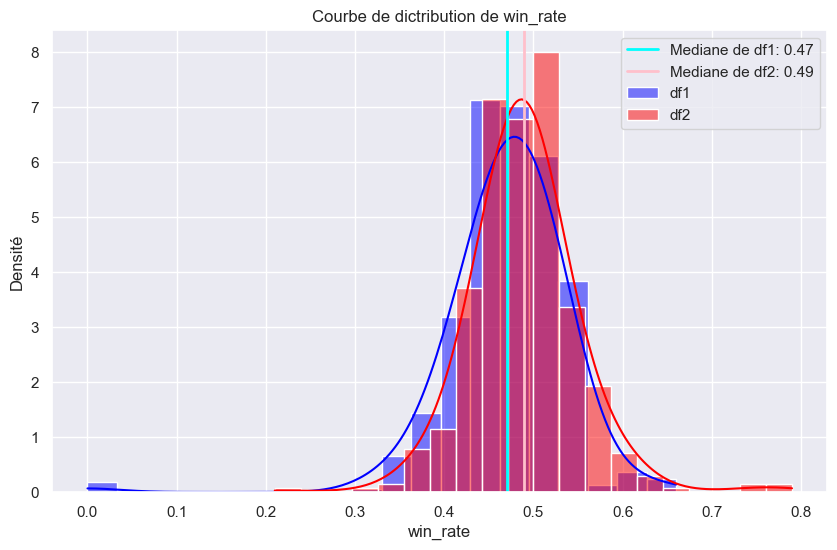

count    506.000000
mean       0.471222
std        0.063665
min        0.000000
25%        0.440000
50%        0.470000
75%        0.510000
max        0.660000
Name: win_rate, dtype: float64 count    483.000000
mean       0.489295
std        0.056979
min        0.210000
25%        0.460000
50%        0.490000
75%        0.520000
max        0.790000
Name: win_rate, dtype: float64


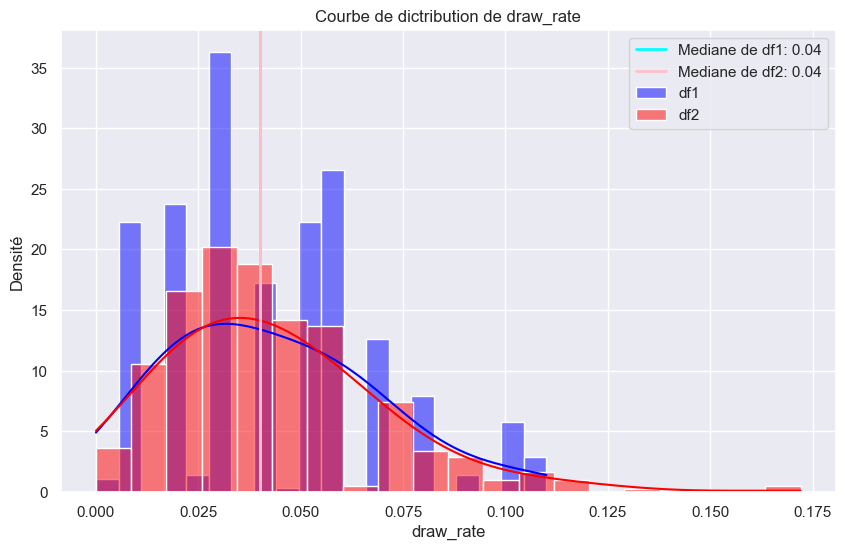

count    506.000000
mean       0.042762
std        0.024510
min        0.000000
25%        0.020000
50%        0.040000
75%        0.060000
max        0.110000
Name: draw_rate, dtype: float64 count    483.000000
mean       0.042327
std        0.025790
min        0.000000
25%        0.020000
50%        0.040000
75%        0.060000
max        0.172043
Name: draw_rate, dtype: float64


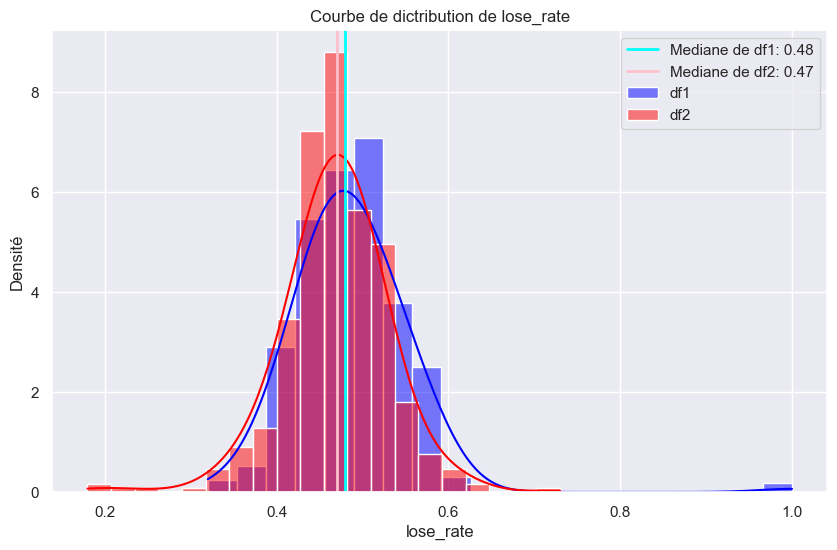

count    506.000000
mean       0.486016
std        0.066014
min        0.320000
25%        0.450000
50%        0.480000
75%        0.520000
max        1.000000
Name: lose_rate, dtype: float64 count    483.000000
mean       0.468378
std        0.058153
min        0.180000
25%        0.440000
50%        0.470000
75%        0.500000
max        0.730000
Name: lose_rate, dtype: float64


In [74]:
comparison_distribution_curve (df_KPI_deutschequalitat, df_KPI_opponents, 'win_rate')
comparison_distribution_curve (df_KPI_deutschequalitat, df_KPI_opponents, 'draw_rate')
comparison_distribution_curve (df_KPI_deutschequalitat, df_KPI_opponents, 'lose_rate')

<font color='red'>

Lorsque l'on compare le taux de victoire `win_rate`, on ne constate pas d'écart significatif entre les adversaires rencontrés et celui de deutschequalitat.

Idem, pour le taux d'égalité `draw_rate`.

Idem pour le taux de défaite `lose_rate`, ce qui est cohérent car il est directement corrélé aux taux de victoires et de nulles.
    
    
<font color = 'green'>
    
Nous allons à présent étudier l'indicateur `last_10_games_score`, afin de vois si oui ou non il y a une différence de ce point de vue.

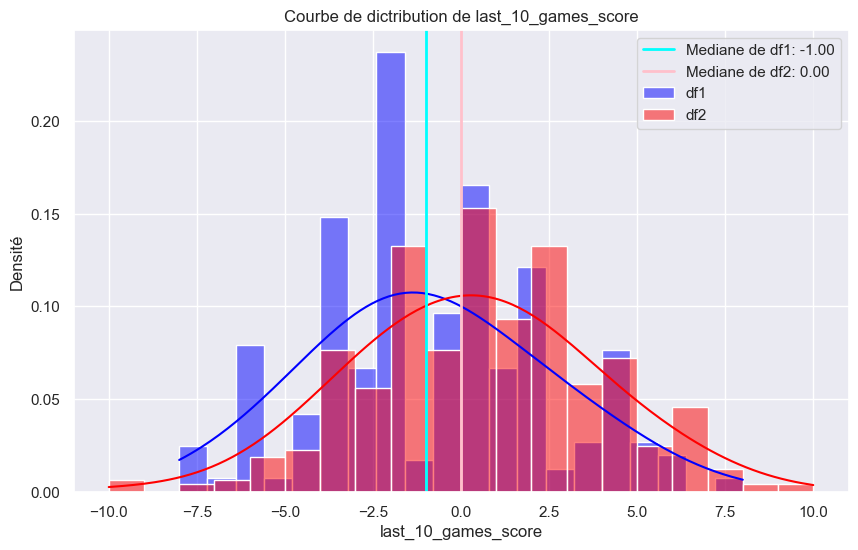

count    506.000000
mean      -0.922925
std        3.203338
min       -8.000000
25%       -3.000000
50%       -1.000000
75%        1.500000
max        8.000000
Name: last_10_games_score, dtype: float64 count    483.000000
mean       0.343685
std        3.249305
min      -10.000000
25%       -2.000000
50%        0.000000
75%        2.000000
max       10.000000
Name: last_10_games_score, dtype: float64


In [75]:
comparison_distribution_curve (df_KPI_deutschequalitat, df_KPI_opponents, 'last_10_games_score')

<font color ='red'>
    
En revanche on constate une différence au niveau de `last_10_games_score`. En effet, la médiane de `last_10_games_score` de deutschequalitat est de 2 tandis que celle des adversaires est de 0. 
On pourrait donc penser qu'il y a un déséquilibrage à ce niveau-là, mais en réalité c'est tout à fait normal.

<font color ='blue'> 
    
1 - D'une part le fait que le score médian des adversaires soit à 0, indique que le site chess.com ne propose pas des adversaires qui soient dans un série de victoires ou de défaites en particulier. Comme la répartition est homogène, on peut conclure sur le fait que chess.com ne choississent pas d'adversaire en particulier pour faire un rééquilibrage.

2 - Le fait que `last_10_games_score` soit égal à -2 pour deutschequalitat est totalement cohérent. Le fait d'avoir considéré, qu'une serie de défaite commençait à partir de 2 défaites de suite, explique que cet indicateur soit en moyenne/médiane à -2.

**Conclusion de l'étude :**

Après avoir analysé ces KPI :
- `best_rating` : correspond au meilleur classement du joueur au moment où nous l'avons affontré
- `win_rate` : part de victoires du joueur sur ses 100 dernières parties
- `draw_rate` : part de parties nulles du joueur sur ses 100 dernières parties
- `lose_rate` : part de défaites du joueur sur ses 100 dernières parties
- `last_10_games_score` : score du joueur sur ses 10 dernières parties : victoire = +1, nulle = 0, défaite = -1

**On ne constate pas de différences significatives qui peuvent nous laisser penser que les adversaires rencontrées sur chess.com sont parfois choisi pour nous faire perdre. En effet, les adversaires rencontrés lors de ces séries de défaites ont en moyenne des indicateurs de performances aussi bons que les nôtres. On en conclue donc qu'il n'y a pas de réquilibrage.**

---
Par ailleurs, il serait intéressant d'analyser les phénomènes qui se déroulent au cours des parties dans des séries de défaites. Voici quelques piste d'interrogations que nous explorerons dans un second temps :
- Y a-t-il une corrélation entre le nombre de parties jouées par jour et le taux de défaites par jour ? (Période de tilt)
- Lors des parties jouées en série de défaite, les statistiques telles que : nombre de coups joués, durées moyenne entre chaque coups, etc. sont-elles significativement différentes ?

# <font color ='green'> Analyse sur le nombre de coups joués par le username étudié

### <font color ='green'> Data loading

In [2]:
#Historique du joueur qu'on étudie, ici deutschequalitat
df_players_historic_deutschequalitat = pd.read_csv(f"./dataframes_saved/df_players_historic_{username}.csv")
df_players_historic_deutschequalitat.head()

,full_histo_idx,game_id,year_month,time_class,end_time,player_username,player_color,player_rating,opponent_username,opponent_color,opponent_rating,player_result
0,234,5528690521,2020/10,rapid,1601660042,deutschequalitat,white,819,pgupta29,black,996,lose
1,235,5528777099,2020/10,rapid,1601661187,deutschequalitat,white,710,AlanJavier9,black,857,lose
2,236,5532006317,2020/10,rapid,1601726701,deutschequalitat,black,616,skinnygorilla,white,698,lose
3,237,5532017711,2020/10,rapid,1601727088,deutschequalitat,white,544,JayC10101,black,622,lose
4,238,5532821435,2020/10,rapid,1601740899,deutschequalitat,white,599,donorBaby,black,512,win


In [3]:
"""
#1ER CHARGEMENT DES DONNES DEPUIS CHESS.COM
df_historic= f.get_player_historic(username)
df_historic.head()
df_historic.drop(2069, inplace=True) #La ligne 2069 est buguée, on la supprime
df_historic = df_historic.reset_index() #On met à jour les index des lignes pour repartir de 0 à x

#On télécharge les coups de la première partie
moves = df_historic['moves'].loc[0] #On récupère les coups sous forme de STR
game_id = df_historic['game_id'].iloc[0] #On donne le game_id pour pouvoir faire le parallele entre la partie jouée et les coups
df_all_moves_from_all_games = f.get_moves_from_a_game(moves, game_id) #On enregistre dans un dataframe
    
#on télécharge les coups de toutes les autres parties
for i in range(df_historic.shape[0]):
    moves = df_historic['moves'].loc[i]
    game_id = df_historic['game_id'].iloc[i]

    #On ajoute à la suite les données chargées
    added_df = f.get_moves_from_a_game(moves, game_id)
    df_all_moves_from_all_games = pd.concat([df_all_moves_from_all_games, added_df], axis=0)
    
#enregistrement du dataframe   
df_all_moves_from_all_games.to_csv(f'./dataframes_saved/df_all_moves_from_all_games_{username}.csv', index=False)

"""

"\n#1ER CHARGEMENT DES DONNES DEPUIS CHESS.COM\ndf_historic= f.get_player_historic(username)\ndf_historic.head()\ndf_historic.drop(2069, inplace=True) #La ligne 2069 est buguée, on la supprime\ndf_historic = df_historic.reset_index() #On met à jour les index des lignes pour repartir de 0 à x\n\n#On télécharge les coups de la première partie\nmoves = df_historic['moves'].loc[0] #On récupère les coups sous forme de STR\ngame_id = df_historic['game_id'].iloc[0] #On donne le game_id pour pouvoir faire le parallele entre la partie jouée et les coups\ndf_all_moves_from_all_games = f.get_moves_from_a_game(moves, game_id) #On enregistre dans un dataframe\n    \n#on télécharge les coups de toutes les autres parties\nfor i in range(df_historic.shape[0]):\n    moves = df_historic['moves'].loc[i]\n    game_id = df_historic['game_id'].iloc[i]\n\n    #On ajoute à la suite les données chargées\n    added_df = f.get_moves_from_a_game(moves, game_id)\n    df_all_moves_from_all_games = pd.concat([df_all

In [4]:
#On importe les coups joués lors des parties
df_all_moves_from_all_games = pd.read_csv(f"./dataframes_saved/df_all_moves_from_all_games_{username}.csv")
df_all_moves_from_all_games.head()

,white_move,white_remaining_time,white_time_to_play_the_move,move_nbr,black_move,black_remaining_time,black_time_to_play_the_move,game_id_ref
0,d4,09:58.800,00:01.200,1,d5,09:54.100,00:05.900,5528690521
1,Nc3,09:56.400,00:02.400,2,Nc6,09:49.800,00:04.300,5528690521
2,e3,09:50.500,00:05.900,3,Nf6,09:32.400,00:17.400,5528690521
3,f3,09:22.200,00:28.300,4,a6,09:27.300,00:05.100,5528690521
4,e4,09:05.500,00:16.700,5,dxe4,09:19.600,00:07.700,5528690521


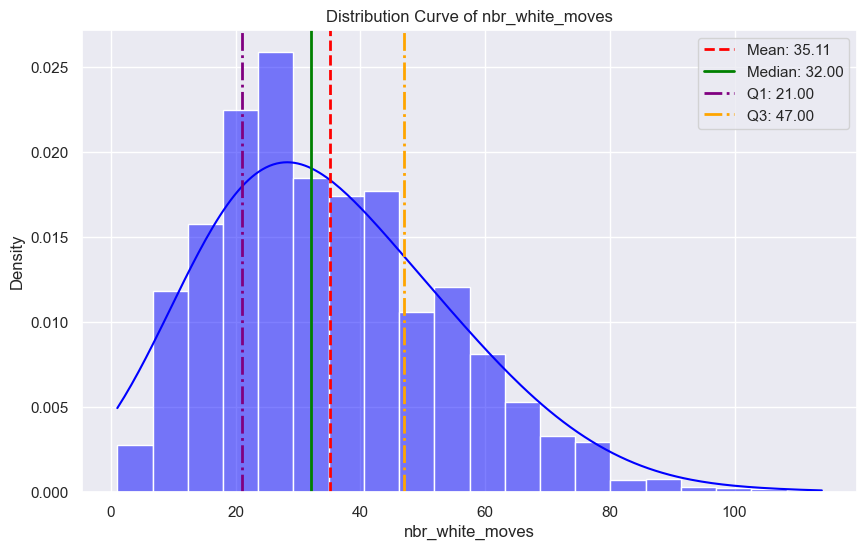

In [5]:
#Nombre de coups par partie sur l'ensemble des parties
q="""
SELECT
    game_id_ref,
    COUNT(white_move) AS nbr_white_moves
FROM df_all_moves_from_all_games
GROUP BY game_id_ref
"""
df_nbr_white_moves_all_games=sqldf(q)

f.distribution_curve(df_nbr_white_moves_all_games, 'nbr_white_moves')

<font color='blue'>
Nous faisons le choix d'étudier le nombre de coups joués par les blancs. 
    
Même si dans certains cas c'est bien le username qui nous intéresse qui a joué les blancs et dans d'autres son adversaire, étant donné que les blancs jouent en premier, on part du principe que le nombre de coups joués par les 2 adversaires est le même, bien que dans la pratique ce ne soit pas toujours le cas.
    
<font color='red'>

Sur l'ensemble des parties jouées par `deutschequalitat`, en moyenne les blancs jouent 35 coups.
- Q1 = 21 coups
- Mediane = 32 coups
- Q3 = 47 coups

La distribution suit une loi normale centrée sur 35. Néanmoins comme la médiane est de 32, on peut conclure qu'il y a une distribution asymétrique vers les valeurs plus élevées.
    
La valeur minimale observée est 1 coup joué par les blanc et la valeur maximale est 114
    
<font color='green'>

A présent, nous allons discriminer les coups joués en fonction de s'il s'agit d'une partie en période de série de défaite ou non

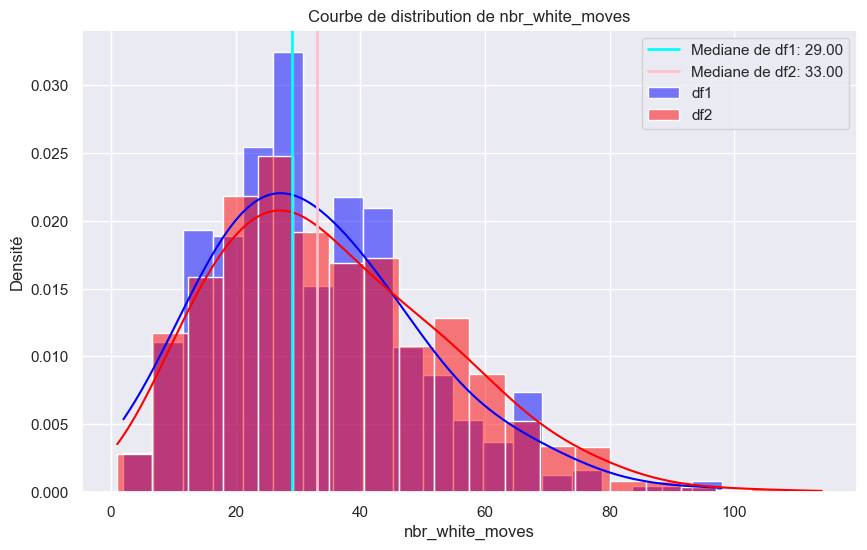

In [6]:
#On récupère les parties des séries de défaites
df_losing_streak_deutschequalitat = pd.read_csv(f"./dataframes_saved/df_losing_streak_deutschequalitat.csv")

#On récupère les game_id des séries de défaites
list_game_id_loosing_streak = df_losing_streak_deutschequalitat['game_id'].unique().tolist()

#On fait un premier dataframe avec les coups des parties des séries de défaites
df_all_moves_from_loosing_streak_games = df_all_moves_from_all_games[df_all_moves_from_all_games['game_id_ref'].isin(list_game_id_loosing_streak)]

#On fait un second dataframe avec les coups des parties des qui NE SONT PAS dans des séries de défaites
df_all_moves_from_not_loosing_streak_games = df_all_moves_from_all_games[~df_all_moves_from_all_games['game_id_ref'].isin(list_game_id_loosing_streak)]

#Nombre de coups par partie sur les parties des séries de défaites
q="""
SELECT
    game_id_ref,
    COUNT(white_move) AS nbr_white_moves
FROM df_all_moves_from_loosing_streak_games
GROUP BY game_id_ref
"""
df_loosing_streak=sqldf(q)

#Nombre de coups par partie sur les parties QUI NE SONT PAS des séries de défaites
q="""
SELECT
    game_id_ref,
    COUNT(white_move) AS nbr_white_moves
FROM df_all_moves_from_not_loosing_streak_games
GROUP BY game_id_ref
"""
df_not_loosing_streak=sqldf(q)

f.comparison_distribution_curve(df_loosing_streak, df_not_loosing_streak, 'nbr_white_moves')

<font color='red'>

Lorsque l'on compare le nombre de coups moyens on constate qu'en période de série de défaite, le joueur jouent en moyenne 3 coups de moins par partie. C'est tout de même 8% de moins par partie.
    
En terme de médiane, la médiane pour les période de série de défaites est de 29 coups tandis qu'elle est de 33 coups pour les périodes en dehors des séries de défaites. Soit 12% de moins.
    
    
<font color='green'>
    
Il serait intéressant de réaliser une comparaison similaire sur la durée moyenne par coups en discriminant de la même façon.
**Attention, cette fois il faudra bien prendre les données en fonction de la couleur jouée par l'utilisateur qu'on étudie**

# <font color ='green'> Analyse sur la durée des coups joués par le username étudié

<font color='green'>
    Dans ce cas d'étude, nous devons sélectionner les données en fonction de la couleur jouée par le joueur. Ainsi, on réalise un dataframe de mapping permettant de s'intéresser dans certains cas aux données des blancs et dans d'autres aux données des noirs.

### <font color ='green'> Data loading

In [7]:
"""
#On crée le dataframe de mapping de couleur
df_color_mapping = pd.DataFrame()
df_color_mapping['game_id'] = df_players_historic_deutschequalitat['game_id']
df_color_mapping['player_color'] = df_players_historic_deutschequalitat['player_color']

df_moves_played_by_username = pd.DataFrame()

game_id = df_color_mapping['game_id'].iloc[0]
color = df_color_mapping['player_color'].loc[0]

df_moves_played_by_username['move_nbr'] = df_time_to_play[df_time_to_play['game_id_ref']==game_id]['move_nbr']
df_moves_played_by_username['time_to_play']=df_time_to_play[df_time_to_play['game_id_ref']==game_id][f'{color}_time_in_s']
df_moves_played_by_username['game_id'] = game_id
df_moves_played_by_username['color'] = color

for i in range(1,df_color_mapping.shape[0]):
    game_id = df_color_mapping['game_id'].iloc[i]
    color = df_color_mapping['player_color'].loc[i]
    
    added_df = pd.DataFrame()
    added_df['move_nbr'] = df_time_to_play[df_time_to_play['game_id_ref']==game_id]['move_nbr']
    added_df['time_to_play']=df_time_to_play[df_time_to_play['game_id_ref']==game_id][f'{color}_time_in_s']
    added_df['game_id'] = game_id
    added_df['color'] = color

    #On ajoute à la suite les données chargées
    df_moves_played_by_username = pd.concat([df_moves_played_by_username, added_df], axis=0)

#enregistrement du dataframe   
df_moves_played_by_username.to_csv(f'./dataframes_saved/df_moves_played_by_{username}.csv', index=False)

"""

"\n#On crée le dataframe de mapping de couleur\ndf_color_mapping = pd.DataFrame()\ndf_color_mapping['game_id'] = df_players_historic_deutschequalitat['game_id']\ndf_color_mapping['player_color'] = df_players_historic_deutschequalitat['player_color']\n\ndf_moves_played_by_username = pd.DataFrame()\n\ngame_id = df_color_mapping['game_id'].iloc[0]\ncolor = df_color_mapping['player_color'].loc[0]\n\ndf_moves_played_by_username['move_nbr'] = df_time_to_play[df_time_to_play['game_id_ref']==game_id]['move_nbr']\ndf_moves_played_by_username['time_to_play']=df_time_to_play[df_time_to_play['game_id_ref']==game_id][f'{color}_time_in_s']\ndf_moves_played_by_username['game_id'] = game_id\ndf_moves_played_by_username['color'] = color\n\nfor i in range(1,df_color_mapping.shape[0]):\n    game_id = df_color_mapping['game_id'].iloc[i]\n    color = df_color_mapping['player_color'].loc[i]\n    \n    added_df = pd.DataFrame()\n    added_df['move_nbr'] = df_time_to_play[df_time_to_play['game_id_ref']==game_

In [9]:
#On importe les coups joués lors des parties
df_time_to_play = pd.read_csv(f"./dataframes_saved/df_all_moves_from_all_games_{username}.csv")

#Pour simplifier on supprime les lignes ou les blancs ont joué un coup mais pas les noirs
df_time_to_play = df_time_to_play[~df_time_to_play['black_time_to_play_the_move'].isna()]

#on convertit les temps en millisecondes
df_time_to_play['white_time_in_s'] = df_time_to_play['white_time_to_play_the_move'].apply(f.convert_string_in_deciseconds)
df_time_to_play['black_time_in_s'] = df_time_to_play['black_time_to_play_the_move'].apply(f.convert_string_in_deciseconds)
df_time_to_play.head()

,white_move,white_remaining_time,white_time_to_play_the_move,move_nbr,black_move,black_remaining_time,black_time_to_play_the_move,game_id_ref,white_time_in_s,black_time_in_s
0,d4,09:58.800,00:01.200,1,d5,09:54.100,00:05.900,5528690521,12,59
1,Nc3,09:56.400,00:02.400,2,Nc6,09:49.800,00:04.300,5528690521,24,43
2,e3,09:50.500,00:05.900,3,Nf6,09:32.400,00:17.400,5528690521,59,174
3,f3,09:22.200,00:28.300,4,a6,09:27.300,00:05.100,5528690521,283,51
4,e4,09:05.500,00:16.700,5,dxe4,09:19.600,00:07.700,5528690521,167,77


In [10]:
#On importe les coups joués lors des parties
df_moves_played_by_deutschequalitat = pd.read_csv(f"./dataframes_saved/df_moves_played_by_deutschequalitat.csv")
df_moves_played_by_deutschequalitat.head()

,move_nbr,time_to_play,game_id,color
0,1,12,5528690521,white
1,2,24,5528690521,white
2,3,59,5528690521,white
3,4,283,5528690521,white
4,5,167,5528690521,white


### <font color='green'>Distinction par couleur de pièce

In [11]:
# Sélectionner les coups joués avec les blancs
df_white = df_moves_played_by_deutschequalitat[df_moves_played_by_deutschequalitat['color'] == 'white']
# Sélectionner les coups joués avec les noirs
df_black = df_moves_played_by_deutschequalitat[df_moves_played_by_deutschequalitat['color'] == 'black']

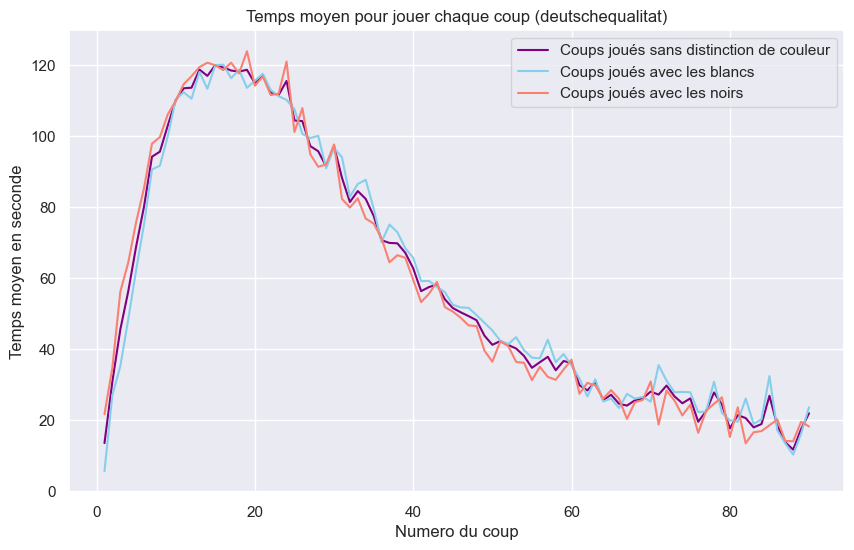

In [12]:
#On étudie la durée moyenne d'un coup en fonction de l'avancée de la partie. On limite l'étude jusqu'au 90e coup car après cela, la volatilité est trop importante
q_all = """
SELECT 
    move_nbr,
    AVG(time_to_play) AS avg_time_to_play
FROM df_moves_played_by_deutschequalitat
GROUP BY move_nbr
ORDER BY move_nbr
"""
df_all_AVG_time_to_play = sqldf(q_all)

# Extraire les données du DataFrame pour les coups joués avec les blancs
move_nbr_all = df_all_AVG_time_to_play['move_nbr'][:90]
AVG_all_time_to_play = df_all_AVG_time_to_play[df_all_AVG_time_to_play['move_nbr']<=90]['avg_time_to_play']

q_white = """
SELECT 
    move_nbr,
    AVG(time_to_play) AS avg_time_to_play
FROM df_white
GROUP BY move_nbr
ORDER BY move_nbr
"""
df_white_AVG_time_to_play = sqldf(q_white)

# Extraire les données du DataFrame pour les coups joués avec les blancs
move_nbr_white = df_white_AVG_time_to_play['move_nbr'][:90]
AVG_white_time_to_play = df_white_AVG_time_to_play[df_white_AVG_time_to_play['move_nbr']<=90]['avg_time_to_play']

q_black = """
SELECT 
    move_nbr,
    AVG(time_to_play) AS avg_time_to_play
FROM df_black
GROUP BY move_nbr
ORDER BY move_nbr
"""
df_black_AVG_time_to_play = sqldf(q_black)

# Extraire les données du DataFrame pour les coups joués avec les noirs
move_nbr_black = df_black_AVG_time_to_play['move_nbr'][:90]
AVG_black_time_to_play = df_black_AVG_time_to_play[df_black_AVG_time_to_play['move_nbr']<=90]['avg_time_to_play']

# Créer les courbes
plt.figure(figsize=(10, 6))
plt.plot(move_nbr_all, AVG_all_time_to_play, color='purple', label='Coups joués sans distinction de couleur')
plt.plot(move_nbr_white, AVG_white_time_to_play, color='skyblue', label='Coups joués avec les blancs')
plt.plot(move_nbr_black, AVG_black_time_to_play, color='salmon', label='Coups joués avec les noirs')

# Ajouter des titres et des étiquettes
plt.title('Temps moyen pour jouer chaque coup (deutschequalitat)')
plt.xlabel('Numero du coup')
plt.ylabel('Temps moyen en seconde')
plt.legend()
plt.grid(True)

# Afficher le graphique
plt.show()

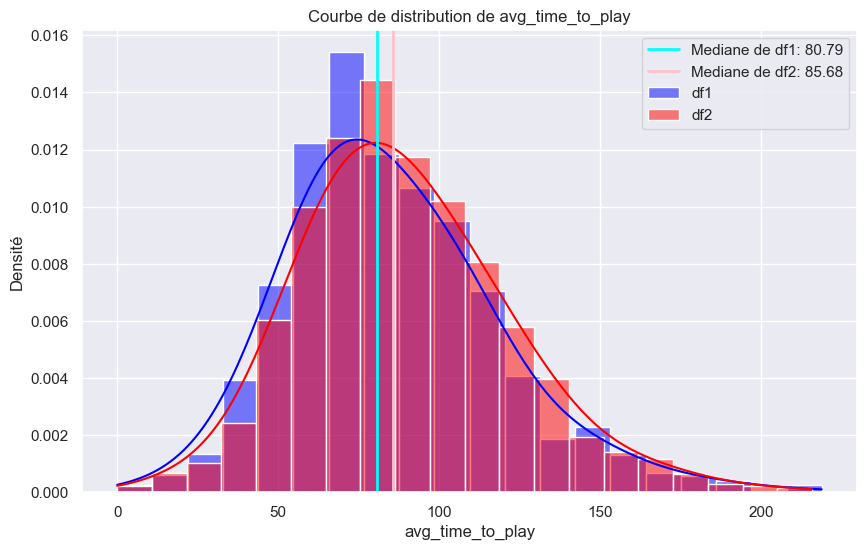

In [13]:
q_white = """
SELECT 
    game_id,
    AVG(time_to_play) AS avg_time_to_play
FROM df_white
GROUP BY game_id
"""
df_white_AVG_time_to_play_per_game = sqldf(q_white)
df_white_AVG_time_to_play_per_game = df_white_AVG_time_to_play_per_game[df_white_AVG_time_to_play_per_game['avg_time_to_play']<=300]

q_black = """
SELECT 
    game_id,
    AVG(time_to_play) AS avg_time_to_play
FROM df_black
GROUP BY game_id
"""
df_black_AVG_time_to_play_per_game = sqldf(q_black)
df_black_AVG_time_to_play_per_game = df_black_AVG_time_to_play_per_game[df_black_AVG_time_to_play_per_game['avg_time_to_play']<=300]

f.comparison_distribution_curve(df_white_AVG_time_to_play_per_game, df_black_AVG_time_to_play_per_game, 'avg_time_to_play')

### <font color = 'green'>Distinction entre périodes de séries de défaites et en dehors

<font color = 'green'>
    
On compare la durée moyenne de réflexion par coup en fonction des parties jouées en période de série de défaite ou en dehors

In [14]:
df_moves_played_by_deutschequalitat.head()
#On récupère les parties des séries de défaites
df_losing_streak_deutschequalitat = pd.read_csv(f"./dataframes_saved/df_losing_streak_deutschequalitat.csv")

#On récupère les game_id des séries de défaites
list_game_id_loosing_streak = df_losing_streak_deutschequalitat['game_id'].unique().tolist()

#On fait un premier dataframe avec les coups des parties des séries de défaites
df_moves_in_loosing_streak_games = df_moves_played_by_deutschequalitat[df_moves_played_by_deutschequalitat['game_id'].isin(list_game_id_loosing_streak)]

#On fait un second dataframe avec les coups des parties des qui NE SONT PAS dans des séries de défaites
df_moves_not_in_loosing_streak_games = df_moves_played_by_deutschequalitat[~df_moves_played_by_deutschequalitat['game_id'].isin(list_game_id_loosing_streak)]

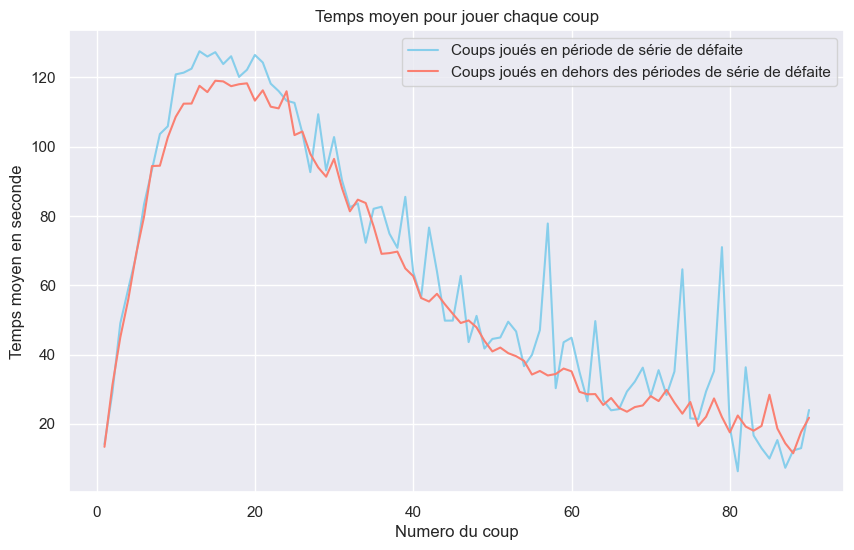

In [15]:
#On étudie la durée moyenne d'un coup en fonction de l'avancée de la partie. On limite l'étude jusqu'au 90e coup car après cela, la volatilité est trop importante
q_loosing_streak = """
SELECT 
    move_nbr,
    AVG(time_to_play) AS avg_time_to_play
FROM df_moves_in_loosing_streak_games
GROUP BY move_nbr
ORDER BY move_nbr
"""
df_loosing_streak_AVG_time_to_play = sqldf(q_loosing_streak)

# Extraire les données du DataFrame pour les coups joués avec les blancs
move_nbr_loosing_streak = df_loosing_streak_AVG_time_to_play['move_nbr'][:90]
AVG_loosing_streak_time_to_play = df_loosing_streak_AVG_time_to_play[df_loosing_streak_AVG_time_to_play['move_nbr']<=90]['avg_time_to_play']

q_NOT_loosing_streak = """
SELECT 
    move_nbr,
    AVG(time_to_play) AS avg_time_to_play
FROM df_moves_not_in_loosing_streak_games
GROUP BY move_nbr
ORDER BY move_nbr
"""
df_NOT_loosing_streak_AVG_time_to_play = sqldf(q_NOT_loosing_streak)

# Extraire les données du DataFrame pour les coups joués avec les blancs
move_nbr_NOT_loosing_streak = df_NOT_loosing_streak_AVG_time_to_play['move_nbr'][:90]
AVG_NOT_loosing_streak_time_to_play = df_NOT_loosing_streak_AVG_time_to_play[df_NOT_loosing_streak_AVG_time_to_play['move_nbr']<=90]['avg_time_to_play']

# Créer les courbes
plt.figure(figsize=(10, 6))
plt.plot(move_nbr_loosing_streak, AVG_loosing_streak_time_to_play, color='skyblue', label='Coups joués en période de série de défaite')
plt.plot(move_nbr_NOT_loosing_streak, AVG_NOT_loosing_streak_time_to_play, color='salmon', label='Coups joués en dehors des périodes de série de défaite')

# Ajouter des titres et des étiquettes
plt.title('Temps moyen pour jouer chaque coup')
plt.xlabel('Numero du coup')
plt.ylabel('Temps moyen en seconde')
plt.legend()
plt.grid(True)

# Afficher le graphique
plt.show()

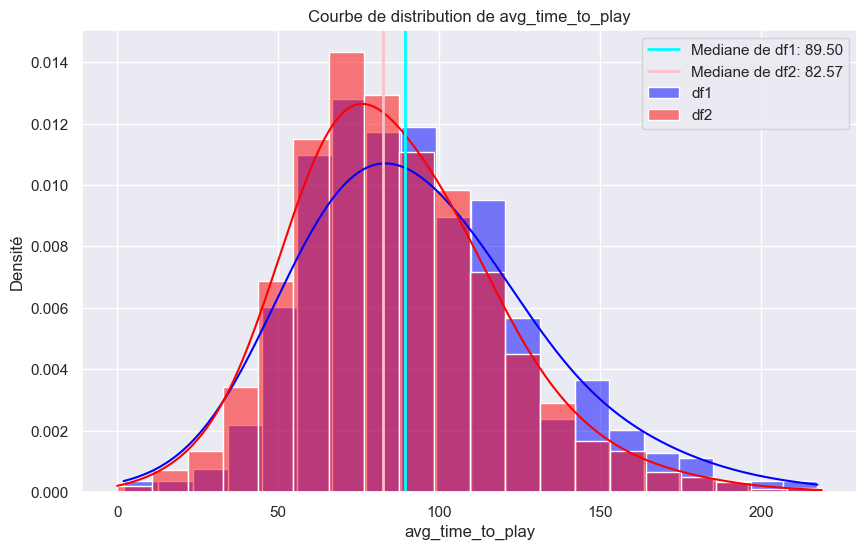

In [16]:
q_loosing_streak = """
SELECT 
    game_id,
    AVG(time_to_play) AS avg_time_to_play
FROM df_moves_in_loosing_streak_games
GROUP BY game_id
"""
df_loosing_streak_AVG_time_to_play_per_game = sqldf(q_loosing_streak)
df_loosing_streak_AVG_time_to_play_per_game = df_loosing_streak_AVG_time_to_play_per_game[df_loosing_streak_AVG_time_to_play_per_game['avg_time_to_play']<=300]

q_not_loosing_streak = """
SELECT 
    game_id,
    AVG(time_to_play) AS avg_time_to_play
FROM df_moves_not_in_loosing_streak_games
GROUP BY game_id
"""
df_not_in_loosing_streak_AVG_time_to_play_per_game = sqldf(q_not_loosing_streak)
df_not_in_loosing_streak_AVG_time_to_play_per_game = df_not_in_loosing_streak_AVG_time_to_play_per_game[df_not_in_loosing_streak_AVG_time_to_play_per_game['avg_time_to_play']<=300]


f.comparison_distribution_curve(df_loosing_streak_AVG_time_to_play_per_game, df_not_in_loosing_streak_AVG_time_to_play_per_game, 'avg_time_to_play')